**Architecture**

<img src="local images/Screenshot 2026-02-04 114455.png" alt="CNN">

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Check GPU Availibility

In [6]:
"""
before starting check if the GPU is available, select it; otherwise use cpu
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device :{device}")

using device :cuda


# Loading and Visualizing the dataset

In [8]:
df_train = pd.read_csv("fmnist/fashion-mnist_train.csv")
# df_test = pd.read_csv("fmnist/fashion-mnist_test.csv")

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


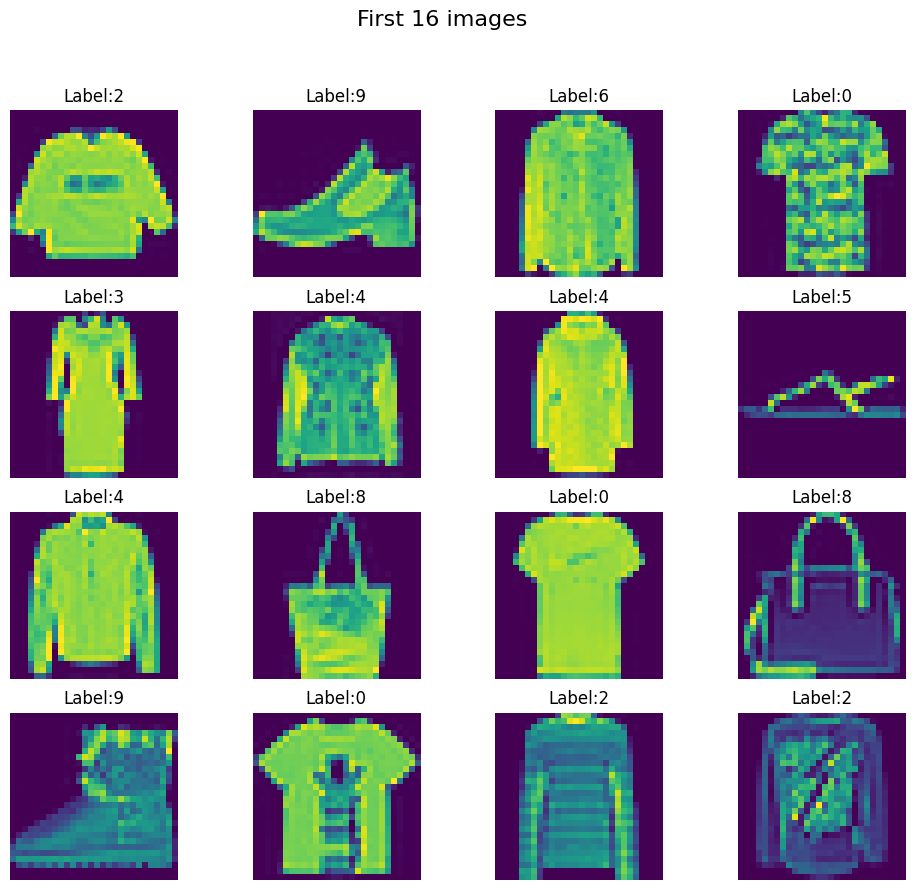

In [9]:
# create a 4x4 grid
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
fig.suptitle("First 16 images", fontsize=16)

# ploting
for i,ax in enumerate(ax.flat):
    img = df_train.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label:{df_train.iloc[i,0]}")

plt.show()

# Spliting data and basic preprocessing

In [10]:
# xtrain = df_train.iloc[:,1:].values
# xtest = df_test.iloc[:,1:].values
# ytrain=df_train.iloc[:,0].values
# ytest=df_test.iloc[:,0].values

x = df_train.iloc[:,1:].values
y = df_train.iloc[:,0].values
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.4)

print(f"xtrain shape:{xtrain.shape}")
print(f"xtest shape:{xtest.shape}")
print(f"ytrain shape:{ytrain.shape}")
print(f"ytest shape:{ytest.shape}")

xtrain shape:(36000, 784)
xtest shape:(24000, 784)
ytrain shape:(36000,)
ytest shape:(24000,)


In [11]:
pre_xtrain_sample = xtrain[0,400:500]

# scaling the features
xtrain = xtrain / 255.0
xtest = xtest / 255.0

# comparing the result
print(f"before scaling :{pre_xtrain_sample}")
print("-"*100)
print(f"after scalling :{xtrain[0,400:500]}")

before scaling :[173 206 108 223  78 166 212 115 132 154 142 170 235 139 188 167 166 162
   0   0   0   0 153 190 200 158 187 216 176 174 176  84 193 194 146 162
 215 199 169  96 221 180 152 193 187 148   0   0   0   0   0   3 160 234
 232 200 129 155 159 175 132 118 209 228  69 127 206 161 223 228 233 160
   0   0   0   0   0   0   0   0   0  28 201 112 191 177 175 198 164 185
 128 211 187 208 156 187  99 204  24   0]
----------------------------------------------------------------------------------------------------
after scalling :[0.67843137 0.80784314 0.42352941 0.8745098  0.30588235 0.65098039
 0.83137255 0.45098039 0.51764706 0.60392157 0.55686275 0.66666667
 0.92156863 0.54509804 0.7372549  0.65490196 0.65098039 0.63529412
 0.         0.         0.         0.         0.6        0.74509804
 0.78431373 0.61960784 0.73333333 0.84705882 0.69019608 0.68235294
 0.69019608 0.32941176 0.75686275 0.76078431 0.57254902 0.63529412
 0.84313725 0.78039216 0.6627451  0.37647059 0.86666667 0.

# Creating CustomDataset Class

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, device):
        self.features = torch.tensor(features, dtype = torch.float32).reshape(-1,1,28,28).to(device)
        self.labels = torch.tensor(labels, dtype = torch.long).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [13]:
# creating train and test dataset object
train_dataset = CustomDataset(xtrain, ytrain,device)
test_dataset = CustomDataset(xtest, ytest,device)

# Enable LoadData Pinning and increase the batchsize

In [14]:
# Creating train test loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Building ANN class

In [15]:
class myNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),
                
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# set Learning_rate and epoch

In [17]:
epochs = 30
Learning_rate = 0.001

# Move the model to GPU

In [18]:
model = myNN(1)
model = model.to(device)
Lossfunction = nn.CrossEntropyLoss()
optimzer = optim.Adam(model.parameters(), lr = Learning_rate,weight_decay=1e-4)

# Modify the traning loop by moving Data to GPU

In [19]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_label in train_loader:

        # moving data to gpu
        # batch_features, batch_label = batch_features.to(device), batch_label.to(device)
        
        # forword pass
        outputs = model(batch_features)
        
        # calcluate loss
        loss = Lossfunction(outputs, batch_label)
        
        # back prop
        optimzer.zero_grad()
        loss.backward()
        
        # upgrade grads
        optimzer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    # priniting the avrage loss per epoch
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch: {epoch+1} , Loss: {avg_loss} , total_epoch_loss:{total_epoch_loss}" )

Epoch: 1 , Loss: 0.5776395041046413 , total_epoch_loss:162.89434015750885
Epoch: 2 , Loss: 0.3452948766185882 , total_epoch_loss:97.37315520644188
Epoch: 3 , Loss: 0.28594488470900986 , total_epoch_loss:80.63645748794079
Epoch: 4 , Loss: 0.25476505192564736 , total_epoch_loss:71.84374464303255
Epoch: 5 , Loss: 0.22363918190095441 , total_epoch_loss:63.066249296069145
Epoch: 6 , Loss: 0.20128415152430534 , total_epoch_loss:56.76213072985411
Epoch: 7 , Loss: 0.18348612509509352 , total_epoch_loss:51.74308727681637
Epoch: 8 , Loss: 0.16584897803552184 , total_epoch_loss:46.76941180601716
Epoch: 9 , Loss: 0.15449338231949097 , total_epoch_loss:43.56713381409645
Epoch: 10 , Loss: 0.14543140197423757 , total_epoch_loss:41.01165535673499
Epoch: 11 , Loss: 0.13007870909645625 , total_epoch_loss:36.68219596520066
Epoch: 12 , Loss: 0.12086604768740582 , total_epoch_loss:34.08422544784844
Epoch: 13 , Loss: 0.11342936038231173 , total_epoch_loss:31.98707962781191
Epoch: 14 , Loss: 0.11372173603967

In [20]:
model.eval()

myNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [21]:
total = 0
correct = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:

        # moving data to gpu
        # batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        output = model(batch_features)
        _, predicted = torch.max(output,1)
        total = total + batch_labels.shape[0]
        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.91275
